# Classification

In [2]:
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### MNIST

_Warning_: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
mnist.data.shape

(70000, 784)

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
28*28

784

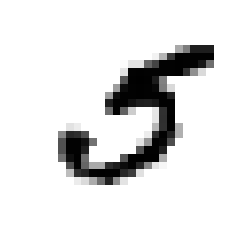

In [9]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
y[36000]

5

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Accuracy using Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95025, 0.96225, 0.9387 ])

Only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

_This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others)._

### Confusion Matrix

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets.

We can use the cross_val_predict() function.

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix (y_train_pred, y_train_5)

array([[52572,   969],
       [ 2007,  4452]], dtype=int64)

<img src="images\confusion_matrix.png">

precision = $\frac{TP}{TP+FP}$

recall = $\frac{TP}{TP+FN}$

$F_{1}$ = $\frac{TP}{TP+\frac{FP+FN}{2}}$

#### Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_pred, y_train_5)

0.8212506917542889

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_pred, y_train_5)

0.7494949494949495

If you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff.

##### Precision/Recall Tradeoff.

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

Note: there was an issue in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of cross_val_predict() was incorrect in the binary classification case when using method="decision_function", as in the code above. The resulting array had an extra first dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hac

In [30]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,
                                                        y_scores)

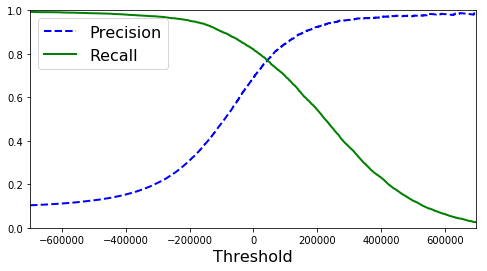

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

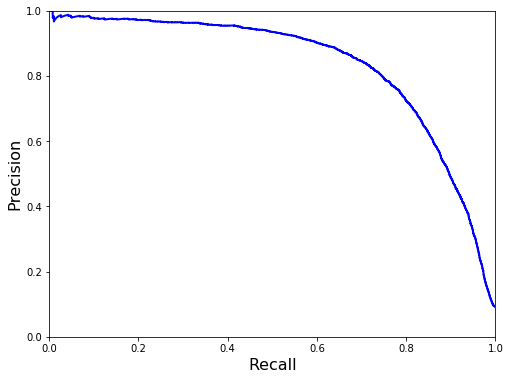

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

The ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

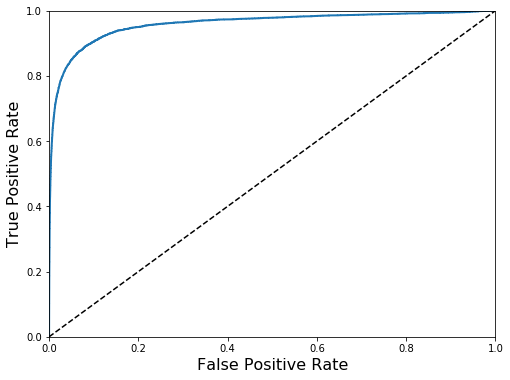

In [37]:
def plot_roc_curve(fpr, trp, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC).

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9590244095435633

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. 

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the topright corner).

## Multiclass classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers:
- One-versus-all (OvA) strategy
- One-versus-one (OvO) strategy

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.
Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

Now of course you want to evaluate these classifiers. As usual, you want to use crossvalidation.

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.82253549, 0.86554328, 0.86693004])

### Error Analysis

First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function.

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5695,    3,    8,    7,    8,   17,   65,    2,  108,   10],
       [   1, 6377,   16,   62,    6,   29,   10,    6,  218,   17],
       [ 119,  113, 4679,  165,   75,   36,  153,   44,  527,   47],
       [  54,   30,   89, 5312,   18,  140,   45,   30,  291,  122],
       [  26,   33,   18,   23, 4846,   20,  112,   30,  311,  423],
       [  84,   41,   19,  324,   66, 4008,  154,   15,  586,  124],
       [  41,   19,   31,    7,   28,   64, 5632,    1,   94,    1],
       [  33,   29,   55,  114,   53,   13,   12, 4977,  185,  794],
       [  75,  278,   63,  151,   60,  364,   58,   23, 4522,  257],
       [  46,   30,    8,  134,  112,   44,    5,  139,  379, 5052]],
      dtype=int64)

It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow() function

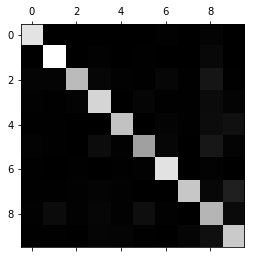

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors.

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result.

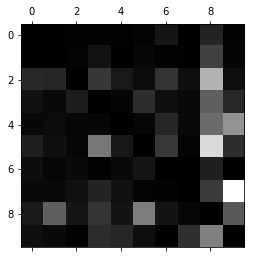

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analyzing the confusion matrix can often give you insights on ways to improve your classifier.
For example, you could try to gather more training data for these digits.